# Model Selection

This notebook will attempt to provide some justification for the particular model chosen for use throughout my final year project. I'll run through my thinking, show how the neural network approach performs in relation to some other likely choices and re-create my hyper-parameter tuning process.

## Requirements

One goal of my project is to answer a fairly broad question: can we use machine learning to make inferences from the readings we'll be taking.

To answer this, we need to do some kind of machine learning. There will be many sub-tasks, both classification and regression. For each one, we could go through a rigorous model selection approach, but it's nice to have one or two good general purpose models that we can use. We don't care so much about the question 'what is the absolute best performance we could achieve here' - all we want to know is whether ML can be useful in solving a given problem. 

So we want to find one or two models that can generalize to the different tasks we'll be trying. The chosen models will need to have the following charachteristics:
- General purpose. Some algorithms might work for one specific problem, but we want a model that can be easily adapted to the different situations
- Robust. We will be using fairly small training datasets, so the model will need some way of combatting overfitting. There is a danger that an overly complicated model will simply fit the noise in the training data and not generalize well.
- Capable of fitting complex functions. Simple linear models might work for some of the problems considered, but a good model would be able to handle the non-linearities inherent in our experimental setup. Light scatters, diffracts, reflects and attenuates. A more complex model would probably be better suited to this kind of problem.

With this in mind, let's load up some data and begin our experiments

In [2]:
# Load up the required libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load the first dataset
df1 = pd.read_csv('dataset_2q.csv')
df1 = df1.drop('Unnamed: 0', axis=1)
df1.head()

/home/jonathan/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,quadrant,object,object_name
0,740,738,733,736,744,727,729,749,721,734,...,554,721,728,727,724,723,727,0,0,empty
1,747,736,736,719,729,734,721,734,729,722,...,543,740,721,741,723,716,724,0,0,empty
2,738,727,730,721,738,734,722,741,734,728,...,552,739,716,714,728,720,740,0,0,empty
3,748,734,738,737,756,743,722,744,728,733,...,550,746,730,724,723,713,730,0,0,empty
4,744,737,740,746,738,746,717,738,737,734,...,539,736,725,731,717,725,732,0,0,empty


This data comes from the ring of 8. Each row contains 72 readings. 8 ADC readings from the PTs with no LEDs illuminated, 8 with the first LED lit, 8 with the second etc. These will be the inputs to our model. The quadrant and object columns are the output variables. We want a model to be able to predict these values based on the inputs.

For a given model, we'll split the data into a training set and a test set. We train the model with the training data, then see how well it performs on the (never before seen) test data. Here, I'm only showing the score for one run. When doing these tests, I generally repeat many times for different (random) test and train sets generated from the initial dataset. This is called cross-validation, and later in this notebook I'll switch to using that to get more accurate comparative scores for choosing the best model. For now, we'll take the more simplistic approach.

In [4]:
# Split the data. X will be the inputs, Y the desired output
X = df1[[str(i) for i in range(72)]] # The readings
y = df1['object'] # What object is in the ring
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Initiate a model. Let's try a simple linear model first. Since this is a classification task, 
# the logistic regression model (aka MaxEnt, logit regression, log-linear classifier) is the typical choice
model = LogisticRegression() # We'll leave the parameters as default for now

# Fit the model to the training data
model.fit(X_train, y_train)

# Score the model on the training data and the test data
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 0.8013333333333333
Score (test data) 0.722


72% accuracy. Not bad! Notice that the score is beter for the training data (expected) but still decent for the test data. This is because by default the model includes a regularization parameter to prevent overfitting. We'll see some models that don't do as well on the test but score nearly 100% on the training data because they don't address this problem.

The next model we'll try is a classic for classification :) Support vector machines.

In [7]:
from sklearn.svm import LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 0.542
Score (test data) 0.522


In [12]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 1.0
Score (test data) 0.19


The first one does pretty badly, and the second is clearly suffering from overfitting. I'll increase the regularization parameter untill we start to get a more generalizeable model. We do this by setting the 'gamma' parameter. Lower gamma means more emphasis on the regularization term.

In [16]:
for g in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    model = SVC(gamma=g)
    model.fit(X_train, y_train)
    print('Score (test data)', model.score(X_test, y_test), 'Gamma:', g)

Score (test data) 0.19 Gamma: 0.1
Score (test data) 0.19 Gamma: 0.01
Score (test data) 0.458 Gamma: 0.001
Score (test data) 0.864 Gamma: 0.0001
Score (test data) 0.806 Gamma: 1e-05


This introduces the idea of hyperparameter tuning. We're tweaking one of the defining attributes of the model and seeing how we can maximise performance. In this case, with gamma=0.0001 we see much better performance than with the default value. This is now our best performing model.

We could probably get our score up a little bit more by tuning some other parameters and tweaking the gamma ever so slightly. But let's move on to other types of models. Here, I'll try a decision tree approach, followed my one of my favourite (for nostalgic reasons) models - Random Forest Classification.

Decision tree:

In [18]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 1.0
Score (test data) 0.646


In [29]:
# And after some tuning, removed for brevity, we still get pretty much the same result
model = tree.DecisionTreeClassifier(max_depth = 8, min_samples_leaf=1)
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 0.814
Score (test data) 0.666


Not great. Dtrees are not really used much - too simple and prone to overfitting.

Random Forest

In [31]:
# First with defualt values
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 0.9953333333333333
Score (test data) 0.742


In [43]:
# Trying some better values for the important parameters. I arrive at these via intuition and
# a bit of experimentation. I'm pretty good at it - see the leaderboard of the competition 
# ongoing at zindi.africa :) There is a general method which one can follow to optimize a random forest model
model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=2)
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 1.0
Score (test data) 0.866


This is roughly as good as the best SVC model, and we haven't yet done much tuning. But scoring on this one test set is a bit misleading, and we might end up picking paramteres that only work for this one random split. So at this point I'll do some housekeeping and introduce a better scoring function.

In [49]:
from sklearn.model_selection import KFold, cross_val_score

# Our new scoring function. Takes a model as input, as well as X and y. Does 5 splits and returns the sum of the scores
def cvs(model, X, y, ns=5):
    k_fold = KFold(n_splits=ns)
    score = 0
    for trains, tests in k_fold.split(X):
        model.fit(X.values[trains], y.values[trains])
        score += model.score(X.values[tests],y.values[tests])
    return score

model1 = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=2)
model2 = model = SVC(gamma=0.0001)

print('Rforest score:', cvs(model1, X, y))
print('SVC score:', cvs(model2, X, y))

Rforest score: 2.9125
SVC score: 2.7100000000000004


The scoring is simple - bigger is better. We could adjust the function to give a meaningful value but all I care about for now is comparison. Notice it takes ages, so I'll stick to the old way untill we need to settle a close contest.

Now for the fun part - neural networks. I have big hopes for this approach, and not just because I've done this before. They're good at this sort of thing. Veng-Pedersen, P. and Modi, N.B., 1992. say they are "are recognized mainly in terms of their adaptive learning and self-organization features and their nonlinear processing capability and are considered most suitable to deal with complex multivariate systems that are poorly understood and difficult to model by classical inductive, logically structured modeling techniques.”

In [51]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()
model.fit(X_train, y_train)
print('Score (training data)', model.score(X_train, y_train))
print('Score (test data)', model.score(X_test, y_test))

Score (training data) 0.2926666666666667
Score (test data) 0.306


What!? That's terrible! Almost as bad as random guessing (there are 5 classes here). What could we be doing wrong?

Well, one important fact: NNs are messed up by input scaling. So the first thing we should do is scale our inputs down to a sensoble range. This is a common problem with a library to solve it for us, so here we go. Take two:

In [57]:
from sklearn.preprocessing import StandardScaler

# This will look at the maximum values and scale accordingly to keep inputs small and manageable
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = MLPClassifier()
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))

Score (training data) 1.0
Score (test data) 0.87


Bam. Top score right away:

In [60]:
cvs(model, pd.DataFrame(scaler.transform(X)), y)

3.53

In [66]:
# And the parameters I used for the project.
model = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))
cvs(model, pd.DataFrame(scaler.transform(X)), y)

Score (training data) 1.0
Score (test data) 0.838


3.725

So why these parameters? Lets vary some things and show that this is the right choice:

In [67]:
# Less hidden layers
model = MLPClassifier(hidden_layer_sizes=(20, 20), max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))
cvs(model, pd.DataFrame(scaler.transform(X)), y)

Score (training data) 1.0
Score (test data) 0.852


3.6700000000000004

In [68]:
# Even less hidden layers
model = MLPClassifier(hidden_layer_sizes=(20), max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))
cvs(model, pd.DataFrame(scaler.transform(X)), y)

Score (training data) 1.0
Score (test data) 0.836


3.46

In [69]:
# More hidden layers
model = MLPClassifier(hidden_layer_sizes=(20, 20, 20, 20), max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))
cvs(model, pd.DataFrame(scaler.transform(X)), y)

Score (training data) 1.0
Score (test data) 0.842


3.6550000000000002

In [73]:
# Even More hidden layers
model = MLPClassifier(hidden_layer_sizes=(20, 20, 20, 20, 20), max_iter=1000)
model.fit(X_train_scaled, y_train)
print('Score (training data)', model.score(X_train_scaled, y_train))
print('Score (test data)', model.score(X_test_scaled, y_test))
cvs(model, pd.DataFrame(scaler.transform(X)), y)

Score (training data) 1.0
Score (test data) 0.844


3.3375

Let's just plot those results quickly, to drive my point home:

Text(0,0.5,'Score')

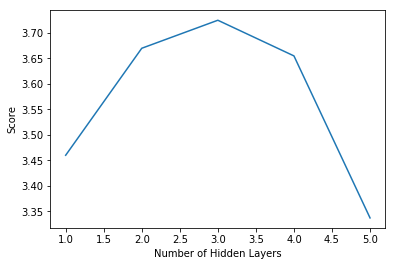

In [74]:
plt.plot([1, 2, 3, 4, 5], [3.46, 3.67, 3.725, 3.655, 3.337])
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')

Text(0,0.5,'Score')

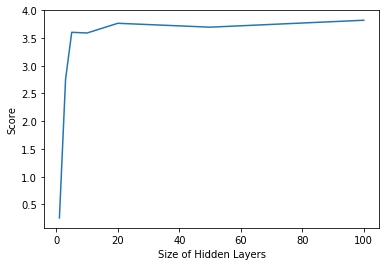

In [75]:
# Varying hidden layer size
scores = []
ns = [1, 3, 5, 10, 20, 50, 100]
for n in ns:
    model = MLPClassifier(hidden_layer_sizes=(n, n, n), max_iter=1000)
    model.fit(X_train_scaled, y_train)
    scores.append(cvs(model, pd.DataFrame(scaler.transform(X)), y))
    
plt.plot(ns, scores)
plt.xlabel('Size of Hidden Layers')
plt.ylabel('Score')

Score stops improving around n=20. Any more, and we're making a model that is needlessly complicated. I haven't found a good rule of thumb for this. More complex tasks (eg image inference) need more neurons, very simple tasks do better with ~10 in each hidden layer. 

#### So, we have a model that outperforms the rest. We might be able to tweak the random forest model to match it's performance, or tweak the model further to squeeze some extra performance out of it. We could also try engineering extra features etc etc. But let's call it good enough, and see if we can use a similar model for some of the other problems we want to try and solve:

## Task 2 - Regression (position inference)

In [ ]:
# Load the data
r8 = pd.read_csv('posinf8_500_readings.csv')